# Elastic Net

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

In [2]:
def xss(y, y_hat):
    y = y.ravel()
    y_hat = y_hat.ravel()
    # Version 1
    tss = ((y - np.average(y)) ** 2).sum()
    rss = ((y_hat - y) ** 2).sum()
    ess = ((y_hat - np.average(y)) ** 2).sum()
    r2 = 1 - rss / tss
    # print 'RSS:', rss, '\t ESS:', ess
    # print 'TSS:', tss, 'RSS + ESS = ', rss + ess
    tss_list.append(tss)
    rss_list.append(rss)
    ess_list.append(ess)
    ess_rss_list.append(rss + ess)
    # Version 2
    # tss = np.var(y)
    # rss = np.average((y_hat - y) ** 2)
    # r2 = 1 - rss / tss
    corr_coef = np.corrcoef(y, y_hat)[0, 1]
    return r2, corr_coef

In [3]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
np.random.seed(0)
np.set_printoptions(linewidth=300)
N = 9
x = np.linspace(0, 6, N) + np.random.randn(N)
x = np.sort(x)
y = x**2 - 4*x - 3 + np.random.randn(N)
x.shape = -1, 1
y.shape = -1, 1

models = [Pipeline([('poly', PolynomialFeatures()),
                    ('linear', LinearRegression(fit_intercept=False))]),
            Pipeline([('poly', PolynomialFeatures()),
                    ('linear', RidgeCV(alphas=np.logspace(-3, 2, 10), fit_intercept=False))]),
            Pipeline([('poly', PolynomialFeatures()),
                    ('linear', LassoCV(alphas=np.logspace(-3, 2, 10), fit_intercept=False))]),
            Pipeline([('poly', PolynomialFeatures()),
                    ('linear', ElasticNetCV(alphas=np.logspace(-3, 2, 10), l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                            fit_intercept=False))])
            ]
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
np.set_printoptions(suppress=True)

线性回归：1阶，系数为： [-12.12113792   3.05477422]
线性回归：2阶，系数为： [-3.23812184 -3.36390661  0.90493645]
线性回归：3阶，系数为： [-3.90207326 -2.61163034  0.66422328  0.02290431]
线性回归：4阶，系数为： [-8.20599769  4.20778207 -2.85304163  0.73902338 -0.05008557]
线性回归：5阶，系数为： [ 21.59733285 -54.12232017  38.43116219 -12.68651476   1.98134176  -0.11572371]
线性回归：6阶，系数为： [ 14.73304785 -37.87317494  23.67462342  -6.07037979   0.42536833   0.06803132  -0.00859246]
线性回归：7阶，系数为： [ 314.30344622 -827.89446924  857.33293186 -465.46543638  144.21883851  -25.67294678    2.44658612   -0.09675941]
线性回归：8阶，系数为： [-1189.50149198  3643.69109456 -4647.92941149  3217.22814712 -1325.87384337   334.32869072   -50.57119119     4.21251817    -0.148521  ]
Ridge回归：1阶，alpha=0.166810，系数为： [-10.79755177   2.75712205]
Ridge回归：2阶，alpha=0.166810，系数为： [-2.86616277 -3.50791358  0.918189  ]
Ridge回归：3阶，alpha=0.046416，系数为： [-3.54779374 -2.8374223   0.70197829  0.02141529]
Ridge回归：4阶，alpha=0.166810，系数为： [-3.04995117 -2.03455252 -0.27692755  0.29868134 -0.02

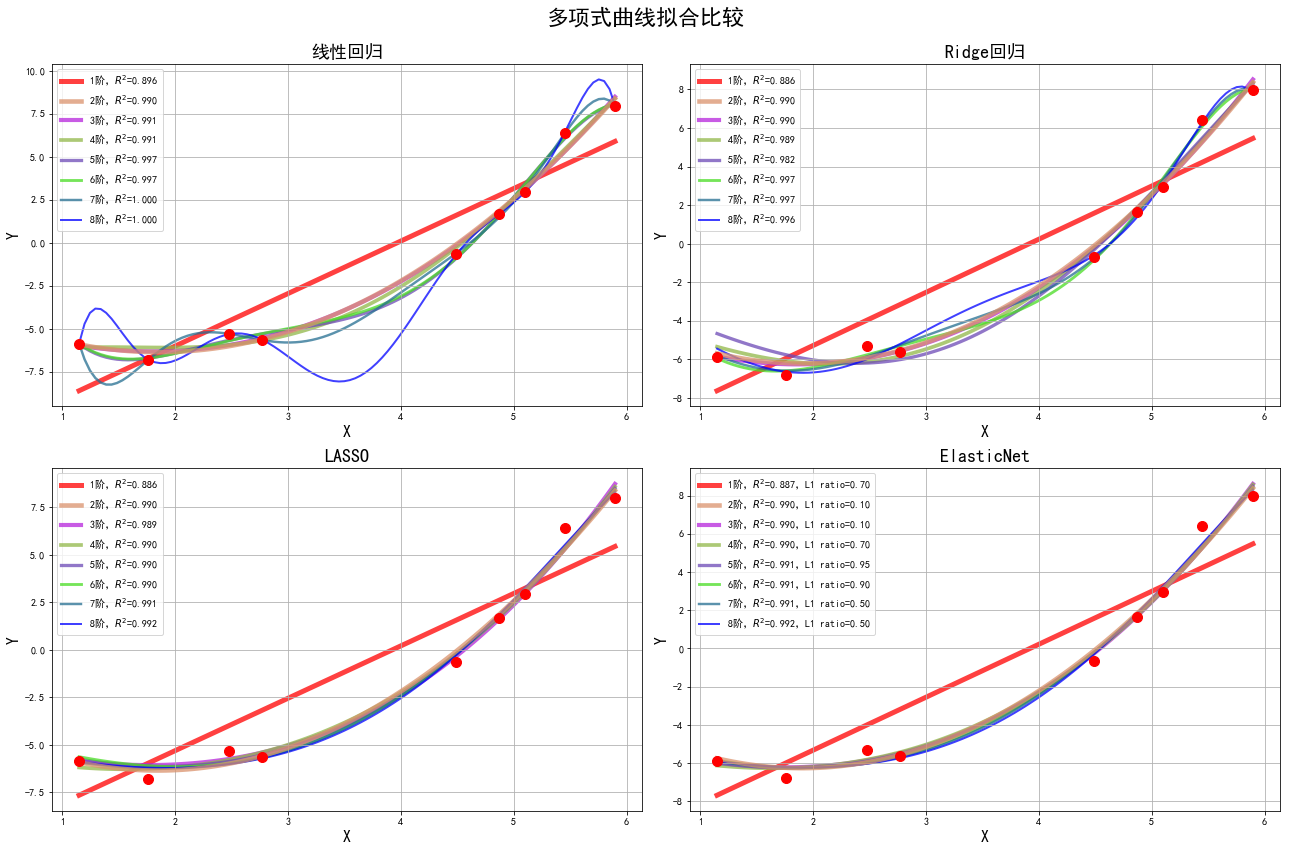

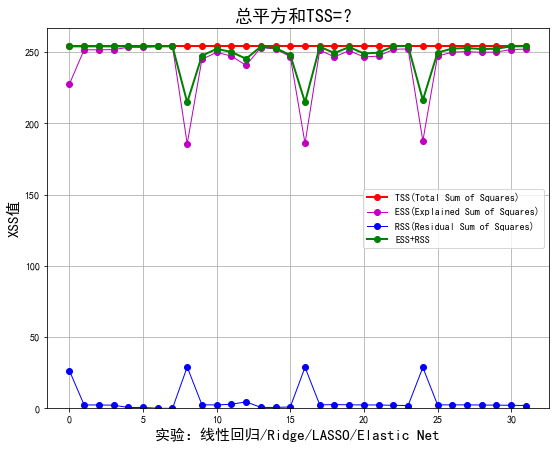

In [4]:
plt.figure(figsize=(18, 12), facecolor='w')
d_pool = np.arange(1, N, 1)  # 阶
m = d_pool.size
clrs = []  # 颜色
for c in np.linspace(16711680, 255, m):
    clrs.append('#%06x' % int(c))
    #clrs.append('#%06x')
line_width = np.linspace(5, 2, m)
titles = u'线性回归', u'Ridge回归', u'LASSO', u'ElasticNet'
tss_list = []
rss_list = []
ess_list = []
ess_rss_list = []
for t in range(4):
    model = models[t]
    plt.subplot(2, 2, t+1)
    plt.plot(x, y, 'ro', ms=10, zorder=N)
    for i, d in enumerate(d_pool):
        model.set_params(poly__degree=d)
        model.fit(x, y.ravel())
        lin = model.get_params('linear')['linear']
        output = u'%s：%d阶，系数为：' % (titles[t], d)
        if hasattr(lin, 'alpha_'):
            idx = output.find(u'系数')
            output = output[:idx] + (u'alpha=%.6f，' % lin.alpha_) + output[idx:]
        if hasattr(lin, 'l1_ratio_'):   # 根据交叉验证结果，从输入l1_ratio(list)中选择的最优l1_ratio_(float)
            idx = output.find(u'系数')
            output = output[:idx] + (u'l1_ratio=%.6f，' % lin.l1_ratio_) + output[idx:]
        print(output, lin.coef_.ravel())
        x_hat = np.linspace(x.min(), x.max(), num=100)
        x_hat.shape = -1, 1
        y_hat = model.predict(x_hat)
        s = model.score(x, y)
        r2, corr_coef = xss(y, model.predict(x))
        # print 'R2和相关系数：', r2, corr_coef
        # print 'R2：', s, '\n'
        z = N - 1 if (d == 2) else 0
        label = u'%d阶，$R^2$=%.3f' % (d, s)
        if hasattr(lin, 'l1_ratio_'):
            label += u'，L1 ratio=%.2f' % lin.l1_ratio_
        plt.plot(x_hat, y_hat, color=clrs[i], lw=line_width[i], alpha=0.75, label=label, zorder=z)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title(titles[t], fontsize=18)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
plt.tight_layout(1, rect=(0, 0, 1, 0.95))
plt.suptitle(u'多项式曲线拟合比较', fontsize=22)
plt.show()

y_max = max(max(tss_list), max(ess_rss_list)) * 1.05
plt.figure(figsize=(9, 7), facecolor='w')
t = np.arange(len(tss_list))
plt.plot(t, tss_list, 'ro-', lw=2, label=u'TSS(Total Sum of Squares)')
plt.plot(t, ess_list, 'mo-', lw=1, label=u'ESS(Explained Sum of Squares)')
plt.plot(t, rss_list, 'bo-', lw=1, label=u'RSS(Residual Sum of Squares)')
plt.plot(t, ess_rss_list, 'go-', lw=2, label=u'ESS+RSS')
plt.ylim((0, y_max))
plt.legend(loc='center right')
plt.xlabel(u'实验：线性回归/Ridge/LASSO/Elastic Net', fontsize=15)
plt.ylabel(u'XSS值', fontsize=15)
plt.title(u'总平方和TSS=？', fontsize=18)
plt.grid(True)
plt.show()